<a href="https://colab.research.google.com/github/fcolombo7/AN2DL-2020/blob/main/challenge3/final_notebooks/4_Rulebased-cat-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AN2DL** - Visual Question Answering challenge

* **Colombo** Filippo - 10559531
* **Del Vecchio** Giovanni - 10570682


# Data import and preprocessing

In [ ]:
from google.colab import drive
import os
from zipfile import ZipFile
drive.mount('/content/drive')

import pathlib
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import collections
import random
import re
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/drive


**How to organize data and folders to run the notebook** 
```
./drive/MyDrive/
└── ANN_project3
    ├── dataset.zip
    └── VQA_Dataset
        ├── test_questions.json
        ├── train_questions_annotations.json
        └── Images
            ├── 0.png
            ├── 1.png
            └── ....png
```

## Load the dataset

In [ ]:
if not os.path.exists('VQA_Dataset'):
  with ZipFile('./drive/MyDrive/ANN_project3/dataset.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
print('The dataset is loaded.')

The dataset is loaded.


## Set up of the parameters

In [ ]:
# Set the seed for random operations. 
SEED = 1234
tf.random.set_seed(SEED)

In [ ]:
#Definitions of constants
drive_root_folder = '/content/drive/MyDrive/ANN_project3/'
apply_data_augmentation = True
IMG_W, IMG_H = 300, 300
batch_size = 16
valid_perc = 0.2

In [ ]:
cwd = os.getcwd()
cwd

'/content'

In [ ]:
dict_path = 'VQA_Dataset/train_questions_annotations.json'
with open(dict_path) as json_file:
    train_dict = json.load(json_file)

In [ ]:
import pandas as pd
df = pd.DataFrame(data=train_dict).transpose()


Hand-crafted categorization vocabulary



In [ ]:
# other
# numeric
# yes/no
# right/left
# who
# doing
types_names = ['other', 'numeric', 'yes/no', 'right/left', 'who', 'doing', 'color']
answer_type = {
        '0': 'numeric',
        '1': 'numeric',
        '2': 'numeric',
        '3': 'numeric',
        '4': 'numeric',
        '5': 'numeric',
        'apple': 'other',
        'baseball': 'other',
        'bench': 'other',
        'bike': 'other',
        'bird': 'other',
        'black': 'color',
        'blanket': 'other',
        'blue': 'color',
        'bone': 'other',
        'book': 'other',
        'boy': 'who',
        'brown': 'color',
        'cat': 'other',
        'chair': 'other',
        'couch': 'other',
        'dog': 'other',
        'floor': 'other',
        'food': 'other',
        'football': 'other',
        'girl': 'who',
        'grass': 'other',
        'gray': 'color',
        'green': 'color',
        'left': 'right/left',
        'log': 'other',
        'man': 'who',
        'monkey bars': 'other',
        'no': 'yes/no',
        'nothing': 'other',
        'orange': 'color',
        'pie': 'other',
        'plant': 'other',
        'playing': 'doing',
        'red': 'color',
        'right': 'right/left',
        'rug': 'other',
        'sandbox': 'other',
        'sitting': 'doing',
        'sleeping': 'doing',
        'soccer': 'other',
        'squirrel': 'other',
        'standing': 'doing',
        'stool': 'other',
        'sunny': 'other',
        'table': 'other',
        'tree': 'other',
        'watermelon': 'other',
        'white': 'color',
        'wine': 'other',
        'woman': 'who',
        'yellow': 'color',
        'yes': 'yes/no'
}

In [ ]:
temp_df = pd.DataFrame(data={'answer': list(answer_type.keys()), 'answer_type': list(answer_type.values())})

In [ ]:
e_df = df.merge(temp_df,on='answer', how='inner')

In [ ]:
e_df.head(20)

,question,image_id,answer,answer_type
0,Who looks happier?,11779,man,who
1,Who is holding the football?,16949,man,who
2,Who cooked the pie?,15616,man,who
3,Who is laughing?,9467,man,who
4,What is the man on the left?,8983,man,who
5,Who is on the couch?,10223,man,who
6,Who is holding the woman's hand?,6030,man,who
7,Who has blonde hair?,7486,man,who
8,Which person is leading the dance?,13337,man,who
9,What is the cat reaching towards?,9974,man,who


Print some statistics.

In [ ]:
e_df[['answer_type', 'question']].groupby('answer_type').describe()

question                                        
               count unique                         top freq
answer_type                                                 
color           6503   1595      What color is the rug?  387
doing           1152    556      What is the dog doing?  131
numeric        10454   3923  How many people are there?  183
other           7870   3765       What is on the table?  173
right/left       581    502         Where is the couch?   13
who              976    725       What is on the couch?   24
yes/no         31296  23048               Is the TV on?  162

## Step 0: Helper functions  definition and Rulebased model

In [ ]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}
def preprocess_english(text):
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
      new_text = new_text + " " + contractions.get(word,word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

Text processing

In [ ]:
import operator

overall_dict = {}
for category in types_names:
  word_dict = {}
  temp_df = e_df.loc[e_df['answer_type']==category]
  questions = temp_df['question'].values
  for quest in questions:
    quest_ = quest
    for c in '!"#$%&()*+.,-/:;=?@[\]^_`{|}~':
      quest_ = quest_.replace(c, '')
    quest_ = preprocess_english(quest_)
    for word in quest_.split():
      if not word in word_dict:
        word_dict[word] = 0
      word_dict[word] += 1
  sorted_tuples = sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True)
  sorted_dict = {k: v for k, v in sorted_tuples}
  overall_dict[category] = sorted_dict

Recurrent words manual inspection

In [ ]:
topk = 10
for key, dict_ in overall_dict.items():
  print(15*'-'+' '+key+f" ({len(e_df.loc[e_df['answer_type'] == key])}) "+'-'*15)
  count = 0
  for k, v in dict_.items():
    count +=1
    #if count <= 2:
    #  continue
    if count > topk+2:
      break
    print(k, v)

--------------- other (7870) ---------------
<start> 7870
<end> 7870
the 7313
is 6764
what 5918
on 2381
where 1493
of 1024
sitting 963
in 884
are 626
woman 597
--------------- numeric (10454) ---------------
<start> 10454
<end> 10454
how 10399
many 10361
are 6724
the 4699
in 2366
there 2222
on 1939
people 1010
picture 596
trees 576
--------------- yes/no (31296) ---------------
the 34557
<start> 31296
<end> 31296
is 20360
a 5887
are 5644
on 4498
there 4024
to 3403
in 3350
man 2940
woman 2717
--------------- right/left (581) ---------------
the 705
<start> 581
<end> 581
is 488
which 274
what 124
on 124
of 123
where 121
side 96
direction 73
right 69
--------------- who (976) ---------------
<start> 976
<end> 976
the 870
is 754
who 644
on 272
what 171
to 124
a 113
which 69
or 69
in 68
--------------- doing (1152) ---------------
the 1541
<start> 1152
<end> 1152
is 1021
what 1001
doing 981
on 234
dog 228
woman 143
are 124
cat 119
man 109
--------------- color (6503) ---------------
the 700

In [ ]:
class QuestionCategorizer(object):
  def __init__(self):
    """
    self.categories = ['other', 
                  'numeric',
                  'yes/no',
                  #'right/left',
                  #'who',
                  'doing',
                  'color']
    """
    self.contain_rules = {'numeric': [['how', 'many'], ['what', 'number']],
             #'right/left': [], come sotto
             #'who': [], #problema... va aggiunto a other?
             'doing': [['what', 'doing']],
             'color': [['what', 'color']], #all combinations of 2 colors? (8 colors in total)
             }

    self.start_rules = {'yesno': ['is', 'are', 'do', 'does', 'should', 'can']}

  def predict(self, question):
    question = preprocess_english(question)
    for c in '!"#$%&()*+.,-/:;=?@[\]^_`{|}~':
      question = question.replace(c, '')

    category = 'other'
    assigned = False
    for cat, rules in self.contain_rules.items():
      for single_rule in rules:
        cond = True
        for word in single_rule:
          if not word in question:
            cond = False
            break
        if cond:
          category = cat
          assigned = True
          break
      if assigned:
        break

    if not assigned:
      for cat, rule in self.start_rules.items():
        for start_word in rule:
          q_vector = question.split()
          q_vector.remove('<start>')
          q_vector.remove('<end>') 
          #print(q_vector)
          #print(q_vector[0], start_word)
          if q_vector[0] == start_word:
            category = cat
            assigned = True
            break
        if assigned:
          break
    return category

In [ ]:
my_obj = QuestionCategorizer()
test = 'Is the obj working?'

In [ ]:
my_obj.predict(test)

#### Analysis on Numeric:

In [ ]:
temp_df = e_df.loc[e_df['answer_type']=='numeric']
questions = temp_df['question']

word = ['how','many']
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  cond = True
  for w in word:
    if not w in q_:
      cond = False
      break
  if not cond:
    other_qs.append(q_)
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
len(df)

100

Now check how many samples on the other categorys I would catch.

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] != 'numeric']
questions = temp_df['question']

word = ['how','many']
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  cond = True
  for w in word:
    if not w in q_:
      cond = False
      break
  if cond:
    other_qs.append(q_)
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
df

,question_


#### Analysis on Color:

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] == 'color']
questions = temp_df['question']

word = ['what', 'color']
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  cond = True
  for w in word:
    if not w in q_:
      cond = False
      break
  if not cond:
    other_qs.append(q_)
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
len(df)

129

Now check how many samples on the other categorys I would catch.

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] != 'color']
questions = temp_df['question']

word = ['what', 'color']
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  cond = True
  for w in word:
    if not w in q_:
      cond = False
      break
  if cond:
    other_qs.append(q_)
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
df

,question_
0,<start> what are the similar colors in the wom...
1,<start> what color is the sofa? <end>
2,<start> what color are the mushrooms? <end>
3,<start> what furniture matches the rug in colo...
4,<start> what object in this room have warm col...
5,<start> what is the same color as the boy shir...
6,<start> what piece of furniture matches the st...
7,<start> what is the light colored creature on ...
8,<start> what does the color of the girl shirt ...
9,<start> what object in the room is the same co...


#### Analysis on Doing:

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] == 'doing']
questions = temp_df['question']

word = ['what', 'doing']
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  cond = True
  for w in word:
    if not w in q_:
      cond = False
      break
  if not cond:
    other_qs.append(q_)
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
len(df)

172

Now check how many samples on the other categorys I would catch.

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] != 'doing']
questions = temp_df['question']

word = ['what','doing']
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  cond = True
  for w in word:
    if not w in q_:
      cond = False
      break
  if cond:
    other_qs.append(q_)
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
df

,question_
0,<start> is the little boy trying to imitate wh...
1,<start> is the boy laughing at what the cat is...
2,<start> is the old lady worried about what the...
3,<start> does the man know what he is doing? <end>
4,<start> are the squirrels interested in what t...
5,<start> what is the young girl doing chasing t...
6,<start> is the woman laughing at what the dogs...
7,<start> is the baby amused at what the woman i...
8,<start> is the girl amused by what the dog and...
9,<start> is the girl laughing at what the boy i...


#### Analysis on Who:

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] == 'who']
questions = temp_df['question']

word = ['who']
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  cond = True
  for w in word:
    if not w in q_:
      cond = False
      break
  if not cond:
    other_qs.append(q_)
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
df

,question_
0,<start> what is the man on the left? <end>
1,<start> which person is leading the dance? <end>
2,<start> what is the cat reaching towards? <end>
3,<start> what is on the log? <end>
4,<start> what is on the blanket? <end>
...,...
315,<start> what is on the slide? <end>
316,<start> which person is going down the slide? ...
317,<start> what do you see in between the two pon...
318,<start> what is the girl laughing at? <end>


Now check how many samples on the other categorys I would catch.

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] != 'who']
questions = temp_df['question']

word = ['who']
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  cond = True
  for w in word:
    if not w in q_:
      cond = False
      break
  if cond:
    other_qs.append(q_)
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
df

,question_
0,<start> will the girl drink the whole bottle o...
1,"<start> are there two people, here, who look a..."
2,<start> is the pie still whole? <end>
3,<start> is the old man wanting to drink the wh...
4,<start> is there an item here associated with ...
...,...
213,<start> who is the girl waving at? <end>
214,<start> who does the eggs belong to? <end>
215,<start> who lives in the tree on the left? <end>
216,<start> who lives in the tree with the squirre...


#### Analysis on right/left:

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] == 'right/left']
questions = temp_df['question']

word = [['left', 'right'], ['which', 'way'], ['which', 'direction'], ['which', 'side'], ['what', 'way'], ['what', 'direction'], ['what', 'side']]
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  buona = False
  for t in word:
    cond = True
    for w in t:
      if not w in q_:
        cond = False
        break
    if cond:
      buona = True
      break
  if not buona:
    other_qs.append(q)  
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
df

,question_
0,Which hand is the boy waving with?
1,Which window is lowest?
2,Which hand is the girl on the floor raising?
3,Which of the two people is younger?
4,Which leg is bent?
...,...
333,Which leg is furthest forward on the dog?
334,Which window is larger?
335,Which girl is closer to the bushes?
336,Where is the tree?


Now check how many samples on the other categorys I would catch.

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] != 'who']
questions = temp_df['question']

word = ['who']
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  cond = True
  for w in word:
    if not w in q_:
      cond = False
      break
  if cond:
    other_qs.append(q_)
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
df

,question_
0,<start> will the girl drink the whole bottle o...
1,"<start> are there two people, here, who look a..."
2,<start> is the pie still whole? <end>
3,<start> is the old man wanting to drink the wh...
4,<start> is there an item here associated with ...
...,...
213,<start> who is the girl waving at? <end>
214,<start> who does the eggs belong to? <end>
215,<start> who lives in the tree on the left? <end>
216,<start> who lives in the tree with the squirre...


#### Analysis on Yes/No:

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] == 'yes/no']
questions = temp_df['question']

word = [['is'], ['are']]
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  buona = False
  for t in word:
    cond = True
    for w in t:
      if not w in q_:
        cond = False
        break
    if cond:
      buona = True
      break
  if not buona:
    other_qs.append(q)  
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
df

,question_
0,Does the dog want the ball?
1,Does the dog belong to the girl?
2,Does the cat want to play?
3,Does each person have a beverage?
4,Do their clothes match?
...,...
4786,Does the boy look excited?
4787,Should the gaming system be on the ground?
4788,Do they notice the deer?
4789,Can the robot think?


Now check how many samples on the other categorys I would catch.

In [ ]:
temp_df = e_df.loc[e_df['answer_type'] != 'yes/no']
questions = temp_df['question']

word = [['is'], ['are']]
other_qs = []
for q in questions:
  q_ = preprocess_english(q)
  buona = False
  for t in word:
    cond = True
    for w in t:
      if not w in q_:
        cond = False
        break
    if cond:
      buona = True
      break
  if buona:
    other_qs.append(q)  
df = pd.DataFrame(data={'question_': np.array(other_qs)}) 

In [ ]:
df

,question_
0,Who is holding the football?
1,Who is laughing?
2,What is the man on the left?
3,Who is on the couch?
4,Who is holding the woman's hand?
...,...
23317,What's the boy looking at?
23318,What is sitting in the tree?
23319,What is the girl on the blanket smiling about?
23320,What type of animal is flying in the sky?


---

Test our custom classifier

In [ ]:
# first change the classes

df = pd.DataFrame(data=train_dict).transpose()

In [ ]:
# other
# numeric
# yes/no
# doing

types_names = ['other', 'numeric', 'yesno', 'doing', 'color']
answer_type = {
        '0': 'numeric',
        '1': 'numeric',
        '2': 'numeric',
        '3': 'numeric',
        '4': 'numeric',
        '5': 'numeric',
        'apple': 'other',
        'baseball': 'other',
        'bench': 'other',
        'bike': 'other',
        'bird': 'other',
        'black': 'color',
        'blanket': 'other',
        'blue': 'color',
        'bone': 'other',
        'book': 'other',
        'boy': 'other',
        'brown': 'color',
        'cat': 'other',
        'chair': 'other',
        'couch': 'other',
        'dog': 'other',
        'floor': 'other',
        'food': 'other',
        'football': 'other',
        'girl': 'other',
        'grass': 'other',
        'gray': 'color',
        'green': 'color',
        'left': 'other',
        'log': 'other',
        'man': 'other',
        'monkey bars': 'other',
        'no': 'yesno',
        'nothing': 'other',
        'orange': 'color',
        'pie': 'other',
        'plant': 'other',
        'playing': 'doing',
        'red': 'color',
        'right': 'other',
        'rug': 'other',
        'sandbox': 'other',
        'sitting': 'doing',
        'sleeping': 'doing',
        'soccer': 'other',
        'squirrel': 'other',
        'standing': 'doing',
        'stool': 'other',
        'sunny': 'other',
        'table': 'other',
        'tree': 'other',
        'watermelon': 'other',
        'white': 'color',
        'wine': 'other',
        'woman': 'other',
        'yellow': 'color',
        'yes': 'yesno'
}

In [ ]:
temp_df = pd.DataFrame(data={'answer': list(answer_type.keys()), 'answer_type': list(answer_type.values())})

In [ ]:
e_df = df.merge(temp_df,on='answer', how='inner')

In [ ]:
my_classifier = QuestionCategorizer()
p_values = np.array([])
for question in e_df['question'].values:
  predicted_class = my_classifier.predict(question)
  print(f"Question: {question}\nCategory: {predicted_class}")
  p_values = np.append(p_values, predicted_class)

In [ ]:
e_df['pred_category'] = p_values
e_df

,question,image_id,answer,answer_type,pred_category
0,Who looks happier?,11779,man,other,other
1,Who is holding the football?,16949,man,other,other
2,Who cooked the pie?,15616,man,other,other
3,Who is laughing?,9467,man,other,other
4,What is the man on the left?,8983,man,other,other
...,...,...,...,...,...
58827,What's the boy looking at?,22709,bird,other,other
58828,What is sitting in the tree?,24396,bird,other,other
58829,What is the girl on the blanket smiling about?,20262,bird,other,other
58830,What type of animal is flying in the sky?,28211,bird,other,other


In [ ]:
count = len(e_df.loc[e_df['answer_type'] == e_df['pred_category']])
tot = len(e_df)
count, tot, count/tot

(56187, 58832, 0.95504147402774)

---

## Prepocessing for the second level models

### Preprocessing of the images using VGG19

We want to extract a feature vector for each image. This is not done during training because it could become a bottleneck, since it is an expensive task.  

So each image is forwarded through the network and the resulting feature vector is stored on the disk.

In [ ]:
#preprocess image before the feature extraction
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_W, IMG_H))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = img * (1./255)
    return img, image_path

#get VGG-19 without dense layers 
def get_VGG19():
    model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape = (IMG_W, IMG_H, 3))
    input_layer = model.input
    hidden_layer = model.layers[-1].output 
    model = tf.keras.Model(input_layer, hidden_layer)
    return model

def get_Xception():
  model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(IMG_W, IMG_H, 3))
  input_layer = model.input
  hidden_layer = model.layers[-1].output 
  model = tf.keras.Model(input_layer, hidden_layer)
  return model

def get_InceptionV3():
  model = tf.keras.applications.InceptionV3( include_top=False, weights="imagenet", input_shape=(IMG_W, IMG_H, 3))
  input_layer = model.input
  hidden_layer = model.layers[-1].output 
  model = tf.keras.Model(input_layer, hidden_layer)
  return model

def get_MobileNetV2():
  model = tf.keras.applications.MobileNetV2( include_top=False, weights="imagenet", input_shape=(IMG_W, IMG_H, 3))
  input_layer = model.input
  hidden_layer = model.layers[-1].output 
  model = tf.keras.Model(input_layer, hidden_layer)
  return model

def extract_features(images, all_image_dict, model_type='VGG'):
    model = None
    if model_type == 'VGG':#300x300 =>81x512
      model = get_VGG19()
    elif model_type =='Inception':
      model = get_InceptionV3()
    elif model_type == 'Xception':
      model = get_Xception()
    elif model_type == 'MobileNetV2':
      model = get_MobileNetV2()

    img_ds = tf.data.Dataset.from_tensor_slices(images)
    img_ds = img_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
    
    ####
    for batch_img, batch_path in img_ds:
        #Extracting features from the batch of images 
        batch_img_features = model(batch_img)
        print(batch_img_features.shape)
        batch_img_features = tf.reshape(batch_img_features, (batch_img_features.shape[0], -1, batch_img_features.shape[3]))
        print(batch_img_features.shape)
        break

    ####

    start_name = 'all_image_dict-'
    end_name = '.pickle' 
    counter = 0
    c_name = 0
    last = False
    if not os.path.exists('all_image_dict-0.pickle'):
      for batch_img, batch_path in img_ds:
        #Extracting features from the batch of images 
        batch_img_features = model(batch_img)
        #print(batch_img_features.shape)
        batch_img_features = tf.reshape(batch_img_features, (batch_img_features.shape[0], -1, batch_img_features.shape[3]))
        #print(batch_img_features.shape)
        #exit(0)
        for img_features, path in zip(batch_img_features, batch_path):
          image_path = path.numpy().decode("utf-8")

          all_image_dict[image_path] = img_features.numpy()
          # Here we split in multiple dictionary as a trick to handle the limited size of the RAM, and to store the embeddings in order to run this feature extractor only one time 
          last = False
          counter +=1
          if counter == 2000:
            name = start_name+str(c_name)+end_name
            with open(name, 'wb') as handle:
              pickle.dump(all_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
              print('serialized feature dict saved. ['+str(c_name)+']')
            all_image_dict={}
            c_name += 1
            counter = 0
            last = True

      if not last:
        name = start_name+str(c_name)+end_name
        with open(name, 'wb') as handle:
          pickle.dump(all_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
          print('serialized feature dict saved. ['+str(c_name)+']')
        all_image_dict={}
        c_name += 1
        counter = 0
        last = True

    else:
      print('serialized feature dict already there.')
    return

In [ ]:
# Get unique images
data_dir = pathlib.Path('VQA_Dataset/Images')
list_imgs = map(lambda x: str(x), list(data_dir.glob('*.png')))
list_imgs = sorted(set(list_imgs))
all_image_dict = {}
extract_features(list_imgs, all_image_dict, model_type='VGG')

80142336/80134624 [==============================] - 0s 0us/step
(16, 9, 9, 512)
(16, 81, 512)
serialized feature dict saved. [0]
serialized feature dict saved. [1]
serialized feature dict saved. [2]
serialized feature dict saved. [3]
serialized feature dict saved. [4]
serialized feature dict saved. [5]
serialized feature dict saved. [6]
serialized feature dict saved. [7]
serialized feature dict saved. [8]
serialized feature dict saved. [9]
serialized feature dict saved. [10]
serialized feature dict saved. [11]
serialized feature dict saved. [12]
serialized feature dict saved. [13]
serialized feature dict saved. [14]


In [ ]:
#Load the embeddings in a dictionary
num = 15
all_image_dict = {}
for k in range(0,num):
  fn = 'all_image_dict-'+str(k)+'.pickle'
  with open(fn, 'rb') as handle:
    temp_dict = pickle.load(handle)
    print(f'Searialized feature dict part {k+1}/{num} loaded.')
  all_image_dict.update(temp_dict)

Searialized feature dict part 1/15 loaded.
Searialized feature dict part 2/15 loaded.
Searialized feature dict part 3/15 loaded.
Searialized feature dict part 4/15 loaded.
Searialized feature dict part 5/15 loaded.
Searialized feature dict part 6/15 loaded.
Searialized feature dict part 7/15 loaded.
Searialized feature dict part 8/15 loaded.
Searialized feature dict part 9/15 loaded.
Searialized feature dict part 10/15 loaded.
Searialized feature dict part 11/15 loaded.
Searialized feature dict part 12/15 loaded.
Searialized feature dict part 13/15 loaded.
Searialized feature dict part 14/15 loaded.
Searialized feature dict part 15/15 loaded.


In [ ]:
del temp_dict

In [ ]:
len(all_image_dict)

29333

### Splitting according to the `answer_type`

In [ ]:
class_map = {}
for n, (key, item) in enumerate(answer_type.items()):
  if not item in class_map:
    class_map[item] = ([],[])
  class_map[item][0].append(key)
  class_map[item][1].append(n)

In [ ]:
class_map

{'color': (['black',
   'blue',
   'brown',
   'gray',
   'green',
   'orange',
   'red',
   'white',
   'yellow'],
  [11, 13, 17, 27, 28, 35, 39, 53, 56]),
 'doing': (['playing', 'sitting', 'sleeping', 'standing'], [38, 43, 44, 47]),
 'numeric': (['0', '1', '2', '3', '4', '5'], [0, 1, 2, 3, 4, 5]),
 'other': (['apple',
   'baseball',
   'bench',
   'bike',
   'bird',
   'blanket',
   'bone',
   'book',
   'boy',
   'cat',
   'chair',
   'couch',
   'dog',
   'floor',
   'food',
   'football',
   'girl',
   'grass',
   'left',
   'log',
   'man',
   'monkey bars',
   'nothing',
   'pie',
   'plant',
   'right',
   'rug',
   'sandbox',
   'soccer',
   'squirrel',
   'stool',
   'sunny',
   'table',
   'tree',
   'watermelon',
   'wine',
   'woman'],
  [6,
   7,
   8,
   9,
   10,
   12,
   14,
   15,
   16,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   29,
   30,
   31,
   32,
   34,
   36,
   37,
   40,
   41,
   42,
   45,
   46,
   48,
   49,
   50,
   51,
   52,


Shuffle the data set to ensure randomicity.

In [ ]:
e_df = e_df.sample(frac = 1, random_state=SEED)

In [ ]:
in_images = np.array(list(map(lambda x: 'VQA_Dataset/Images/'+ x +'.png', e_df['image_id'].values)), dtype='object')
in_questions = e_df['question'].values
out_answer = e_df['answer'].values
q_class = e_df['answer_type'].values

### Preprocessing of the questions through tokenization

In [ ]:
in_questions = np.array([preprocess_english(el) for el in in_questions])
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(in_questions)
in_seqs = tokenizer.texts_to_sequences(np.array(in_questions))

#Padding
question_vector = tf.keras.preprocessing.sequence.pad_sequences(in_seqs, padding='post')

Build a data structure that contains the splitted data. 

In [ ]:
input_data = {} # class : (images, question_vector, out_answer)
for q_type in types_names:
  idx = np.where(q_class == q_type) 
  input_data[q_type] = (in_images[idx], question_vector[idx], out_answer[idx])

In [ ]:
input_data['yesno'][0].shape, input_data['yesno'][1].shape, input_data['yesno'][2].shape

((31296,), (31296, 23), (31296,))

## Second level model

In [ ]:
types_names

['other', 'numeric', 'yesno', 'doing', 'color']

In [ ]:
#here the model you want to build and train 
selected_category = 'other'

### Prprocessing of the answers: OHE  

In [ ]:
from sklearn.preprocessing import OneHotEncoder

answer_encoder = OneHotEncoder(dtype=np.int32, sparse=False)
answer_encoder.fit(np.unique(class_map[selected_category][0]).reshape(-1,1))
answer_values = answer_encoder.transform(input_data[selected_category][2].reshape(-1,1))

In [ ]:
answer_values[0].shape, len(class_map[selected_category][0])

((37,), 37)

### Dataset: train and validation sets 

Limit the size of the training set due to time and memory contraints.

In [ ]:
max_num_samples = 10000

In [ ]:
num_samples = input_data[selected_category][0].shape[0]
if  num_samples < max_num_samples:
  mask = range(num_samples)
else:
  mask = range(max_num_samples)

In [ ]:
len(mask), num_samples, max_num_samples

(9427, 9427, 10000)

Split in train and validation data.

In [ ]:
from sklearn.model_selection import train_test_split
train_idx, valid_idx = train_test_split(mask, test_size = valid_perc, random_state = SEED) 

Definition of the `tf.data.Dataset` objects.

In [ ]:
def get_image_tensor(img, ques):
    img_tensor = all_image_dict[img.decode('utf-8')]
    return img_tensor, ques

def create_dataset(image_paths, question_vec, answer_vec):
    dataset_input = tf.data.Dataset.from_tensor_slices((image_paths, question_vec.astype(np.float32)))
    dataset_output = tf.data.Dataset.from_tensor_slices((answer_vec.astype(np.float32)))
    
    # load the numpy files in parallel
    dataset_input = dataset_input.map(lambda img, ques : tf.numpy_function(get_image_tensor, [img, ques], [tf.float32, tf.float32]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

    #dataset_input = dataset_input.batch(batch_size)
    #dataset_output = dataset_output.batch(batch_size)#.repeat() #occhio!
    
    dataset = tf.data.Dataset.zip((dataset_input, dataset_output))
    dataset = dataset.batch(batch_size).repeat()
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE) #occhio!
    return dataset

In [ ]:
train_images = input_data[selected_category][0][train_idx]
train_questions = input_data[selected_category][1][train_idx]
train_answers = answer_values[train_idx]

valid_images = input_data[selected_category][0][valid_idx]
valid_questions = input_data[selected_category][1][valid_idx]
valid_answers = answer_values[valid_idx]

In [ ]:
dataset_train = create_dataset(train_images, train_questions, train_answers)
dataset_valid = create_dataset(valid_images, valid_questions, valid_answers)

In [ ]:
dataset_train

<PrefetchDataset shapes: ((<unknown>, <unknown>), (None, 37)), types: ((tf.float32, tf.float32), tf.float32)>

### Hierarchical Question-Image Co-Attention
[Source paper](https://arxiv.org/pdf/1606.00061v5.pdf)



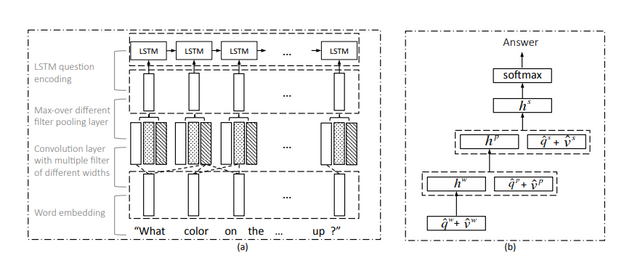

In [ ]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self, num_classes, num_embeddings, dropout_rate=0.3, hidden_size=512):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.dropout = dropout_rate
        self.num_embeddings = num_embeddings
        

        self.image_dense = tf.keras.layers.Dense(self.hidden_size) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size)

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size)
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1)

        self.img_atten = tf.keras.layers.Dense(1)

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size)
                                               #embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same')
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', dilation_rate = 2)
        
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = self.hidden_size , return_sequences=True, dropout = self.dropout)
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal())
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax', input_shape = (self.hidden_size,))
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        # atten for image feature
        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [ ]:
len(tokenizer.word_index)

4540

In [ ]:
def get_coattention_model(num_classes):
    image_input = tf.keras.layers.Input(shape = (81, 512))

    question_input = tf.keras.layers.Input(shape=(train_questions.shape[1],))

    output = CoattentionModel(num_classes=num_classes, 
                              num_embeddings=len(tokenizer.word_index)+1,
                              dropout_rate=0.2)(image_input, question_input) #num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input, question_input], outputs = output)

    return model

In [ ]:
model = get_coattention_model(len(class_map[selected_category][0]))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 81, 512)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
coattention_model (CoattentionM (None, 37)           8925735     input_2[0][0]                    
                                                                 input_3[0][0]                    
Total params: 8,925,735
Trainable params: 8,925,735
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
loss = tf.keras.losses.CategoricalCrossentropy()
# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)    

In [ ]:
TRAIN_NOW = False

In [ ]:
name = 'model_v2-1_AdaptLR'
if TRAIN_NOW:
  model.fit(x = dataset_train,
            epochs = 30,
            steps_per_epoch = len(train_idx),
            validation_data = dataset_valid,
            validation_steps = len(valid_idx), 
            callbacks = get_callbacks(selected_category + '_' + name, es=True, LR=True, patience=3))
else:
  print('Train skipped.')

Epoch 1/30
7541/7541 [==============================] - 384s 51ms/step - loss: 2.7356 - accuracy: 0.1947 - val_loss: 2.0726 - val_accuracy: 0.3490
Epoch 2/30
7541/7541 [==============================] - 382s 51ms/step - loss: 1.6607 - accuracy: 0.4460 - val_loss: 1.7005 - val_accuracy: 0.4571
Epoch 3/30
7541/7541 [==============================] - 384s 51ms/step - loss: 1.1430 - accuracy: 0.5987 - val_loss: 1.6596 - val_accuracy: 0.5023
Epoch 4/30
7541/7541 [==============================] - 407s 54ms/step - loss: 0.8314 - accuracy: 0.7045 - val_loss: 1.7551 - val_accuracy: 0.5039
Epoch 5/30
7541/7541 [==============================] - 404s 54ms/step - loss: 0.6041 - accuracy: 0.7893 - val_loss: 1.9058 - val_accuracy: 0.5166
Epoch 6/30
7541/7541 [==============================] - 406s 54ms/step - loss: 0.4303 - accuracy: 0.8543 - val_loss: 2.1528 - val_accuracy: 0.5098


In [ ]:
LOAD_NOW = False

In [ ]:
if LOAD_NOW:
  model_to_load = selected_category+'_'+'model_v2-1_AdaptLR' #check the model name in the drive folder (the time stamp changes)
  ckpt_path = os.path.join(drive_root_folder,'experiments_results',model_to_load, 'ckpts','cp.ckpt')
  model.load_weights(ckpt_path)


---

Load all the models.

In [ ]:
model_embedding = get_VGG19()

In [ ]:
models={}
for cat in types_names:
  m = get_coattention_model(len(class_map[cat][0]))
  model_to_load = cat+'_'+'model_v2-1_AdaptLR'
  ckpt_path = os.path.join(drive_root_folder,'experiments_results',model_to_load, 'ckpts','cp.ckpt')
  m.load_weights(ckpt_path)
  models[cat] = m

In [ ]:
models

{'color': <tensorflow.python.keras.engine.functional.Functional at 0x7fc93f4177b8>,
 'doing': <tensorflow.python.keras.engine.functional.Functional at 0x7fc93f673cf8>,
 'numeric': <tensorflow.python.keras.engine.functional.Functional at 0x7fc93fab4710>,
 'other': <tensorflow.python.keras.engine.functional.Functional at 0x7fc93fc3a588>,
 'yesno': <tensorflow.python.keras.engine.functional.Functional at 0x7fc93f7be828>}

In [ ]:
labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

## Submission

In [ ]:
'''model_to_load = 'coattention_model_v4-l3' #check the model name in the drive folder (the time stamp changes)
ckpt_path = os.path.join(drive_root_folder,'experiments_results',model_to_load, 'ckpts','cp.ckpt')
model = get_coattention_model()
model.load_weights(ckpt_path)
model_vgg = get_VGG19()'''

In [ ]:
custom_classifier = QuestionCategorizer()

In [ ]:
import os
from datetime import datetime

def predict(ques, verbose=True):
  test_image_path = 'VQA_Dataset/Images/' + ques[1]['image_id'] + '.png'  
  input_value = preprocess_english(ques[1]['question'])

  #tokenization
  tokenizer_top = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  tokenizer_top.fit_on_texts(input_value)
  in_seqs = tokenizer_top.texts_to_sequences(input_value)

  #Padding
  input_vector = tf.keras.preprocessing.sequence.pad_sequences(in_seqs, padding='post')

  #prediction = question_model(tf.expand_dims(input_vector, 0))
  #predicted_label = np.argmax(prediction)
  #pred_class = question_label_encoder.categories_[0][predicted_label]
  pred_class = custom_classifier.predict(ques[1]['question'])

  map_pred = class_map[pred_class][1]
  #model_to_load = pred_class + '_blabla'
  #ckpt_path = os.path.join(drive_root_folder,'experiments_results',model_to_load, 'ckpts','cp.ckpt')
  #model = get_coattention_model()
  #model.load_weights(ckpt_path)
  model = models[pred_class]

  test_image_features = model_embedding(tf.expand_dims(load_image(test_image_path)[0], 0))
  test_image_features = np.reshape(test_image_features,(1, -1,test_image_features.shape[-1]))
  test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([preprocess_english(ques[1]['question'])]),padding='post',
                                                                            maxlen=train_questions.shape[1])
  
  #test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([ques[1]['question']]),padding='post',
  #                                                                          maxlen=train_questions.shape[1])
  
  y_pred = model.predict([test_image_features,test_question_features])
  final_pred = map_pred[np.argmax(y_pred)]
  if verbose:
    print(30*'-')
    print(f"Question: {ques[1]['question']}")
    print(f"Pred category: {pred_class}")
    print(f"Prediction: {np.argmax(y_pred)} ['{class_map[pred_class][0][np.argmax(y_pred)]}' -> {final_pred}]")
  return final_pred

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
sub_dict = {}
test_path = 'VQA_Dataset/test_questions.json'
with open(test_path) as json_file:
    test_dict = json.load(json_file)

for quest in test_dict.items():
  sub_dict[quest[0]] = predict(quest)

In [ ]:
create_csv(sub_dict, drive_root_folder)